#import libraries

In [20]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt

#import yelp review data set and save data into csv file

In [2]:
# Once you excute this code sucessfully no need to run it again
with open('yelp_academic_dataset_review.json', 'r', encoding='utf-8') as json_type_file:
    data = [json.loads(line) for line in json_type_file]

In [6]:
# count length of the array
number_of_rows = len(data)
number_of_rows

6990280

In [3]:
# add data into a dataframe
df = pd.DataFrame(data)

In [4]:
df.head(10)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
5,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31
6,6AxgBCNX_PNTOxmbRSwcKQ,r3zeYsv1XFBRA4dJpL78cw,gmjsEdUsKpj9Xxu6pdjH0g,5.0,0,2,0,Loved this tour! I grabbed a groupon and the p...,2015-01-03 23:21:18
7,_ZeMknuYdlQcUqng_Im3yg,yfFzsLmaWF2d4Sr0UNbBgg,LHSTtnW3YHCeUkRDGyJOyw,5.0,2,0,0,Amazingly amazing wings and homemade bleu chee...,2015-08-07 02:29:16
8,ZKvDG2sBvHVdF5oBNUOpAQ,wSTuiTk-sKNdcFyprzZAjg,B5XSoSG3SfvQGtKEGQ1tSQ,3.0,1,1,0,This easter instead of going to Lopez Lake we ...,2016-03-30 22:46:33
9,pUycOfUwM8vqX7KjRRhUEA,59MxRhNVhU9MYndMkz0wtw,gebiRewfieSdtt17PTW6Zg,3.0,0,0,0,Had a party of 6 here for hibachi. Our waitres...,2016-07-25 07:31:06


In [5]:
# save it in a csv file
df.to_csv('yelp_reviews.csv', index=False)

In [2]:
# import csv file
df1 = pd.read_csv('yelp_reviews.csv')

In [3]:
df1.shape

(6990280, 9)

#data cleaning

In [4]:
df1.head(6)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
5,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31


In [5]:
df2 = df1.drop(['review_id','user_id','business_id','useful','funny','cool','date'] ,axis=1 , inplace=False)

In [6]:
df2.head(6)

,stars,text
0,3.0,"If you decide to eat here, just be aware it is..."
1,5.0,I've taken a lot of spin classes over the year...
2,3.0,Family diner. Had the buffet. Eclectic assortm...
3,5.0,"Wow! Yummy, different, delicious. Our favo..."
4,4.0,Cute interior and owner (?) gave us tour of up...
5,1.0,I am a long term frequent customer of this est...


In [7]:
df2.isnull().sum()

stars    0
text     0
dtype: int64

In [8]:
df2.duplicated().sum()

14858

In [9]:
df3 = df2.drop_duplicates(inplace=False)

In [10]:
df3.duplicated().sum()

0

In [11]:
df3.head(6)

,stars,text
0,3.0,"If you decide to eat here, just be aware it is..."
1,5.0,I've taken a lot of spin classes over the year...
2,3.0,Family diner. Had the buffet. Eclectic assortm...
3,5.0,"Wow! Yummy, different, delicious. Our favo..."
4,4.0,Cute interior and owner (?) gave us tour of up...
5,1.0,I am a long term frequent customer of this est...


<Axes: title={'center': 'Review Stars'}, xlabel='stars'>

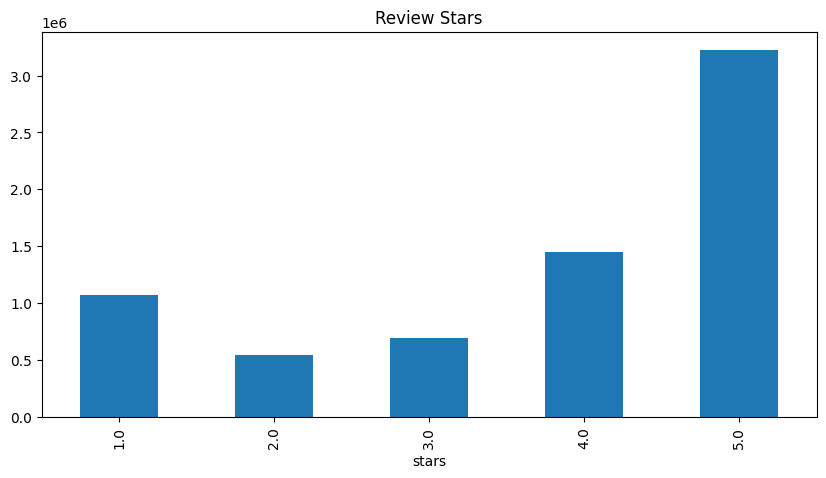

In [12]:
df3['stars'].value_counts().sort_index().plot(kind='bar', title="Review Stars", figsize=(10,5))

In [15]:
# 0 - negative
# 1 - neutral
# 2 - positive

# Function to convert score to sentiment
def sentiment(rating):
    
    rating = int(rating)
    # Convert to class
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

# Apply to the dataset 
df3['sentiment'] = df3['stars'].apply(sentiment)

C:\Users\Genuka K Manthila\AppData\Local\Temp\ipykernel_6280\6595409.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['sentiment'] = df3['stars'].apply(sentiment)


In [18]:
df3.head(10)

,stars,text,sentiment
0,3.0,"If you decide to eat here, just be aware it is...",1
1,5.0,I've taken a lot of spin classes over the year...,2
2,3.0,Family diner. Had the buffet. Eclectic assortm...,1
3,5.0,"Wow! Yummy, different, delicious. Our favo...",2
4,4.0,Cute interior and owner (?) gave us tour of up...,2
5,1.0,I am a long term frequent customer of this est...,0
6,5.0,Loved this tour! I grabbed a groupon and the p...,2
7,5.0,Amazingly amazing wings and homemade bleu chee...,2
8,3.0,This easter instead of going to Lopez Lake we ...,1
9,3.0,Had a party of 6 here for hibachi. Our waitres...,1


<Axes: title={'center': 'Review Stars'}, xlabel='sentiment'>

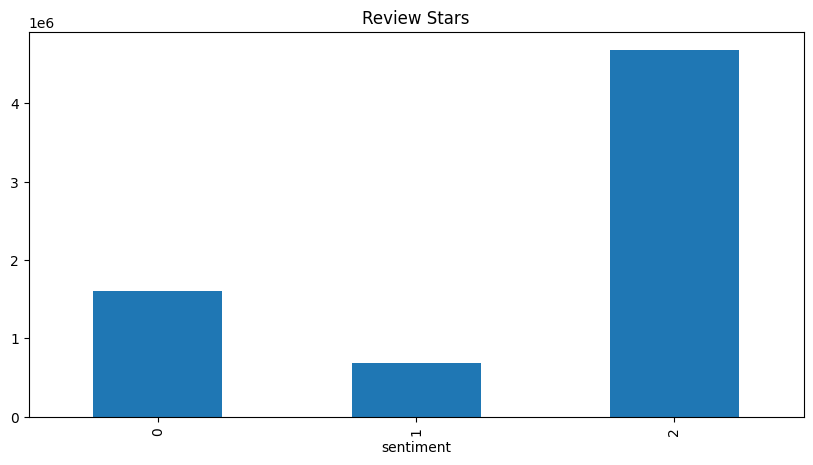

In [19]:
df3['sentiment'].value_counts().sort_index().plot(kind='bar', title="Review Stars", figsize=(10,5))